# DeePC Implementation

### Packages

In [1083]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel
%matplotlib inline

## Recht system

In [1084]:
A = np.array([[1.01, 0.01, 0.00], # A - State-space matrix
              [0.01, 1.01, 0.01], 
              [0.00, 0.01, 1.01]]) 
B = np.eye(3) # B - State-space matrix
C = np.eye(3) # C - State-space matrix
D = np.zeros([3,3]) # D - State-space matrix

n = A.shape[0] # n = number of states
m = B.shape[1] # m = number of inputs
p = C.shape[0] # p = number of output
q = m+p # q = number of i/o variables

Tini = 3                                   # Past time horizon                                           
Tf = 3                                     # Future time horizon         
T = (m+1)*(Tini + Tf + n) - 1                               


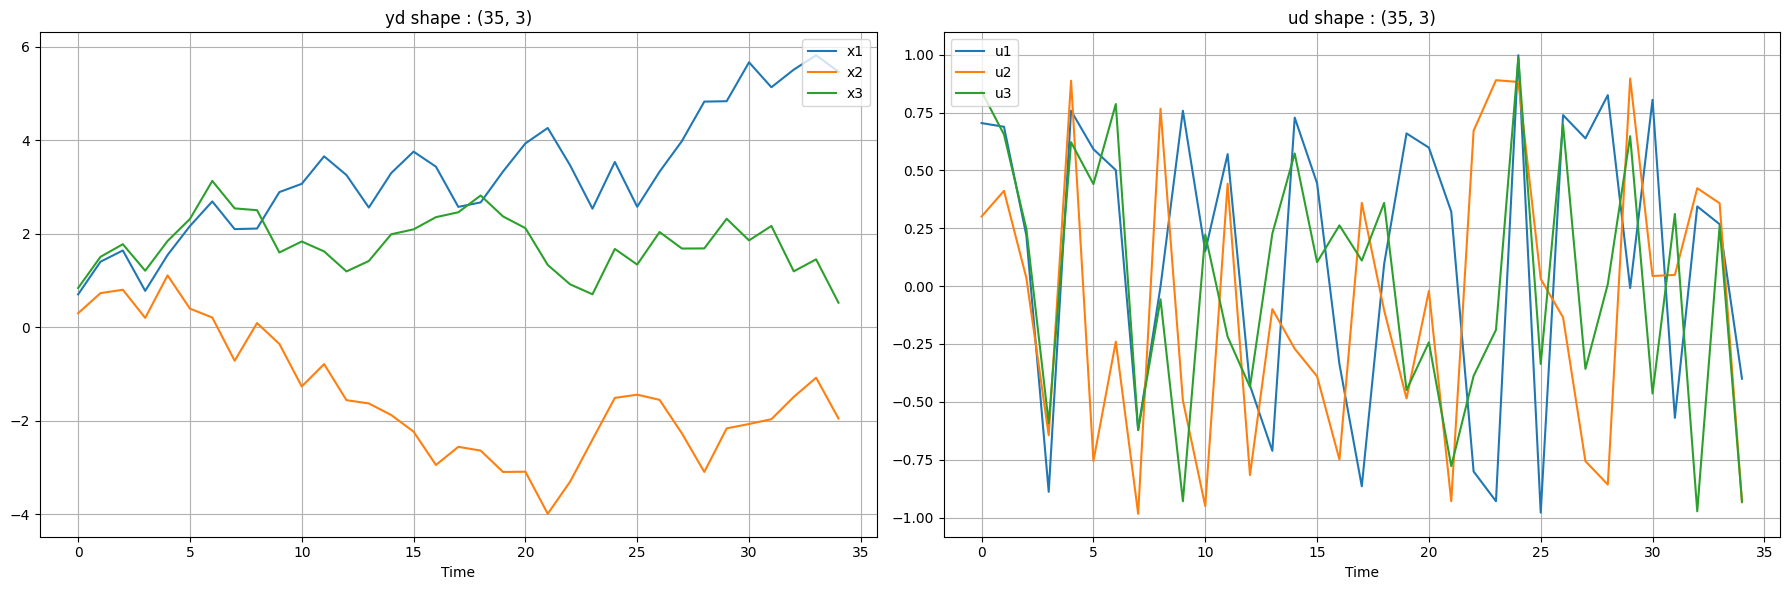

In [1085]:
ud = []
yd = []
x = np.array([0,0,0])
for i in range(T):
   u = np.random.uniform(low=-1, high=1, size=(m,)) # Random input
   x = A@x + B@u
   y = C@x + D@u
   ud.append(u)
   yd.append(y)
ud = np.array(ud)
yd = np.array(yd)

# print(f'ud shape : {ud.shape}, yd shape : {yd.shape}')
plt.rcParams["figure.figsize"] = (18,6)
plt.subplot(1,2,1)
plt.plot(range(0,35), yd, label=['x1', 'x2', 'x3'])
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title(f"yd shape : {yd.shape}")
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,35), ud, label=['u1', 'u2', 'u3'])
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.title(f"ud shape : {ud.shape}")
plt.grid('on')
plt.tight_layout()

plt.show()

In [1086]:
L = Tini + Tf + n
u_row, u_col = ud.shape
H_u = np.zeros((m*L, T-L+1))
ud = ud.reshape((u_row*u_col,))
for i in range(0,T-L+1):
   H_u[:,i] = ud[m*i:m*(L+i)]
print(f'H has rank {np.linalg.matrix_rank(H_u)} and shape {H_u.shape}')

H has rank 27 and shape (27, 27)


In [1087]:
L = Tini + Tf
U = np.zeros((m*L, T-L+1))
for i in range(0,T-L+1):
   U[:,i] = ud[m*i:m*(L+i)]

y_row, y_col = yd.shape
yd = yd.reshape((y_row * y_col,))

Y = np.zeros((p*L, T-L+1))
for i in range(0,T-L+1):
   Y[:,i] = yd[p*i:p*(L+i)]

In [1088]:
u_ini = ud[0:Tini*m]
y_ini = yd[0:Tini*p]
# u_ini = np.zeros(Tini*m)
# y_ini = np.zeros(Tini*p)
# print(f'u_ini : {u_ini}\ny_ini : {y_ini}')

In [1089]:
print(Y.shape)
print(U.shape)

(18, 30)
(18, 30)


In [1090]:
Up = U[0:m*Tini,:]
Yp = Y[0:p*Tini,:]
Uf = U[Tini*m:,:]
Yf = Y[Tini*p:,:]
print(f'Up shape : {Up.shape}, Yp shape : {Yp.shape}, Uf shape : {Uf.shape}, Yf shape: {Yf.shape}')

Up shape : (9, 30), Yp shape : (9, 30), Uf shape : (9, 30), Yf shape: (9, 30)


In [1091]:
# x = np.array([0,0,0])
# y1 = x
# u1 = np.array([0,0,0])
# x = A@x + u1
# y2 = x
# u2 = np.array([0.3,-0.1,0.6])
# x = A@x + u2
# y3 = x
# u3 = np.array([-0.1, 0.7, -1])
# x = A@x + u3
# y4 = x
# u_ini = np.array([*u1, *u2, *u3])
# y_ini = np.array([*y1, *y2, *y3])

# print(f'u ini : {u_ini}\ny ini : {y_ini}')

In [1092]:
u = cp.Variable(Tf*m)
g = cp.Variable(T-Tini-Tf+1)
y = cp.Variable(Tf*p)

Q = np.eye(Tf*p)*10
r = np.kron(np.ones(Tf), np.array([0,1,0.5]))
R = np.eye(Tf*m)*1

cost = cp.quad_form(y-r,Q) + cp.quad_form(u,R)

constraints = [
    Up@g == u_ini,
    Yp@g == y_ini,
    Uf@g == u,
    Yf@g == y,
    cp.abs(u) <= 0.5
]

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(solver=cp.OSQP, verbose=True)

# print(prob.variables()[0].value) --> Y value
# print(prob.variables()[1].value) --> U value

# uT = [*u_ini]
# yT = [*y_ini]

# for i in range(0,20):

#     action = prob.variables()[].value[:m]
#     print(action)
#     x = A@x + B@action
#     obs = C@x + D@action
#     print(obs)

#     u_ini = np.array(uT[-m*Tini:])
#     y_ini = np.array(yT[-p*Tini:])
#     print(u_ini)
#     constraints = [
#         Up@g == u_ini,
#         Yp@g == y_ini,
#         Uf@g == u,
#         Yf@g == y
#     ]

#     prob = cp.Problem(cp.Minimize(cost), constraints)
#     prob.solve(solver=cp.OSQP, verbose=False)



                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 03 07:03:16 PM: Your problem has 48 variables, 5 constraints, and 0 parameters.
(CVXPY) Mar 03 07:03:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 03 07:03:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 03 07:03:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 03 07:03:16 PM: Compiling problem (target solver=OSQP).
(CVXPY) Mar 03 07:03:16 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

## Inveretd Pendulum

In [1093]:
import gym
import mujoco_py
from gym import wrappers
from IPython import display

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
obs = env.reset()

ud = []
yd = []
done = False
for i in range(27):
    action = env.action_space.sample()
    obs, rew, done, info, _ = env.step(action)
    ud.append(action)
    yd.append(obs)

env.close()

ud = np.array(ud)
yd = np.array(yd)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [1094]:
T_ini = 4
n = 4
N = 5
env.close()
T = len(ud)

print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')

L = T_ini + N + n
H = hankel(ud[0:L], ud[L:])
print(f'H has rank {np.linalg.matrix_rank(H)} and shape {H.shape}')

yd shape : (27, 4)   ud shape : (27, 1)
H has rank 13 and shape (13, 14)


In [1095]:
L = T_ini + N
yd = yd.reshape((27*4,))

U = hankel(ud[0:L], ud[L:])
Y = np.zeros((L*4, 27-L+1))

for i in range(0,T-L+1):
    Y[:,i] = yd[4*i:4*(L+i)]

Up = U[0:T_ini, :]
Uf = U[T_ini:, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:4*T_ini, :]
Yf = Y[4*T_ini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')

u_ini = ud[3:3+T_ini].reshape((T_ini,))
y_ini = yd[12:12+4*T_ini].reshape((4*T_ini,))


U = (9, 18), Up = (4, 18), Uf = (5, 18)
Y = (36, 19), Yp = (16, 19), Yf = (20, 19)


## Solver

In [1096]:
g = cp.Variable(T - T_ini - N)
u = cp.Variable(N)
y = cp.Variable(N*4)
sig_y = cp.Variable(4*T_ini)

Q = np.eye(N*4)
R = np.eye(N)*0.01
x_lower = np.ones(N)*0
x_upper = np.ones(N)*3

u_constraint = np.ones(N)*3

cost = cp.quad_form(y, Q) + cp.quad_form(u,R) + cp.norm1(g)*10 + cp.norm1(sig_y)*0.01

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
obs = env.reset()
done = False
yT = [*y_ini]
uT = [*u_ini]
# print(yT)

for i in range(30):

  constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini + sig_y,
    Uf @ g == u,
    Yf @ g == y,
    # A@g == b,
    cp.abs(u) <= u_constraint
    # cp.abs(u[1::2]) <= steer_constraint,
    # y <= x_upper,
    # y >= x_lower
  ]

  prob = cp.Problem(cp.Minimize(cost), constraints)
  prob.solve(solver=cp.OSQP, verbose=False)

  # for i in range(T_ini):
  plt.imshow(env.render())
  display.display(plt.gcf())    
  display.clear_output(wait=True)
  action = prob.variables()[1].value[0]
  # print(action)
  obs,_,_,_,_ = env.step([action])
  uT.append(action)
  for o in obs:
    yT.append(o) 
    
  # print(yT)
  u_ini = np.array(uT[-4:]).reshape(4,)
  y_ini = np.array(yT[-16:]).reshape(16,)





ValueError: Incompatible dimensions (16, 19) (18, 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(136,)


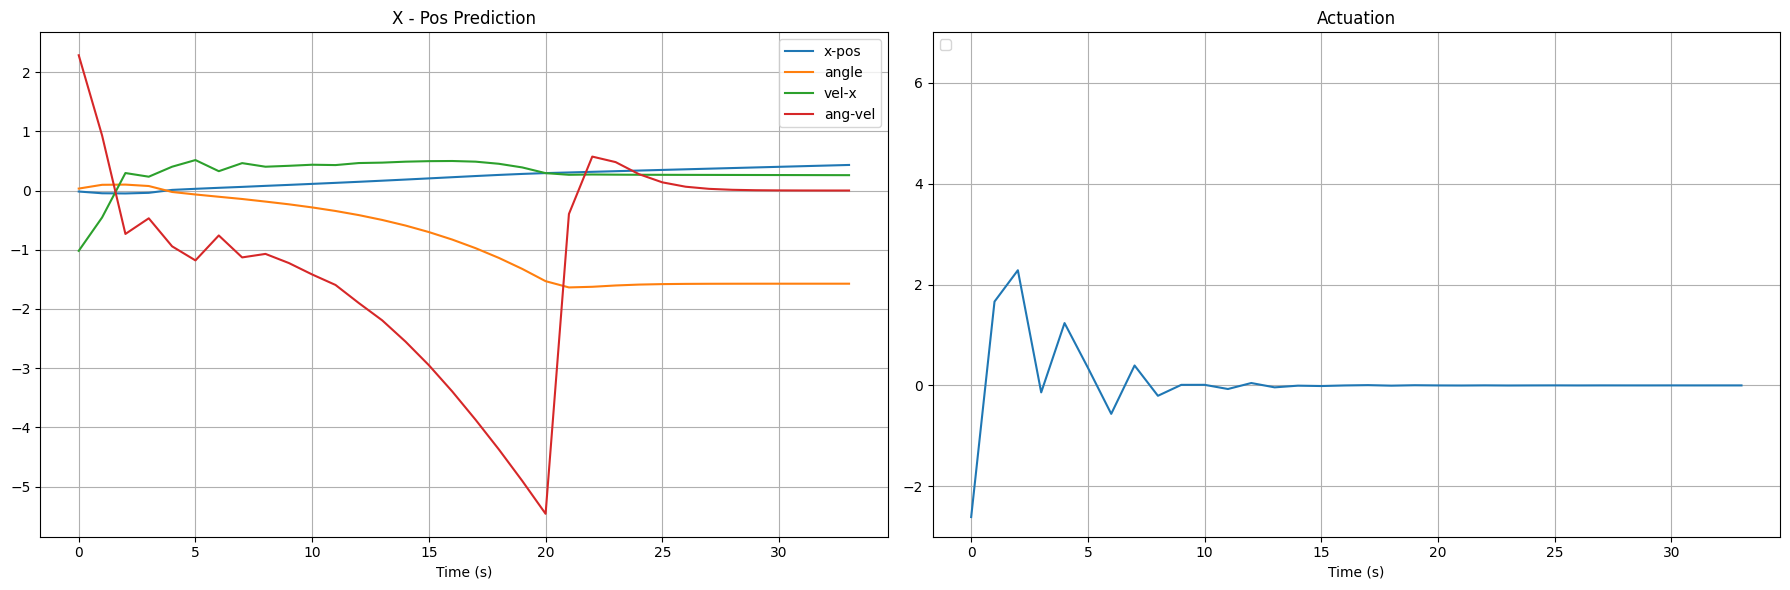

In [ ]:
# time = np.array(list(range(0,N)))
# y = prob.variables()[0].value
# u = prob.variables()[1].value
yT = np.array(yT)
print(yT.shape)
yT = yT.reshape((34,4))
plt.subplot(1,2,1)
plt.plot(range(0,34), yT, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.legend(loc="upper right")
plt.xlabel('Time (s)')
plt.title("X - Pos Prediction")
# plt.ylim((-3,7))
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,34), uT)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation")
plt.ylim((-3,7))
plt.grid('on')
plt.tight_layout()

plt.show()

In [ ]:
A = np.array([
    [1,1,1,1],
    [2,2,2,2],
    [3,3,3,3],
    [4,4,4,4],
    [5,5,5,5],
    [6,6,6,6],
    [7,7,7,7],
])

# Get shape of A
(row,col) = A.shape
A = A.reshape((row*col,))

# Define L and T
L = 2
T = 7

# Fill in Hankel
H = np.zeros((L*col, T-L+1))
for i in range(0,T-L+1):
    H[:,i] = A[4*i:4*(L+i)]
H

array([[1., 2., 3., 4., 5., 6.],
       [1., 2., 3., 4., 5., 6.],
       [1., 2., 3., 4., 5., 6.],
       [1., 2., 3., 4., 5., 6.],
       [2., 3., 4., 5., 6., 7.],
       [2., 3., 4., 5., 6., 7.],
       [2., 3., 4., 5., 6., 7.],
       [2., 3., 4., 5., 6., 7.]])